# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [2]:
# imports
from google.colab import drive
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GaussianNoise
from keras.layers import Conv2D, MaxPool2D, Input
from keras.layers.convolutional import MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, InceptionV3
from sklearn.model_selection import train_test_split

In [6]:
DIR = "/content/drive/MyDrive/train_val"

In [7]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

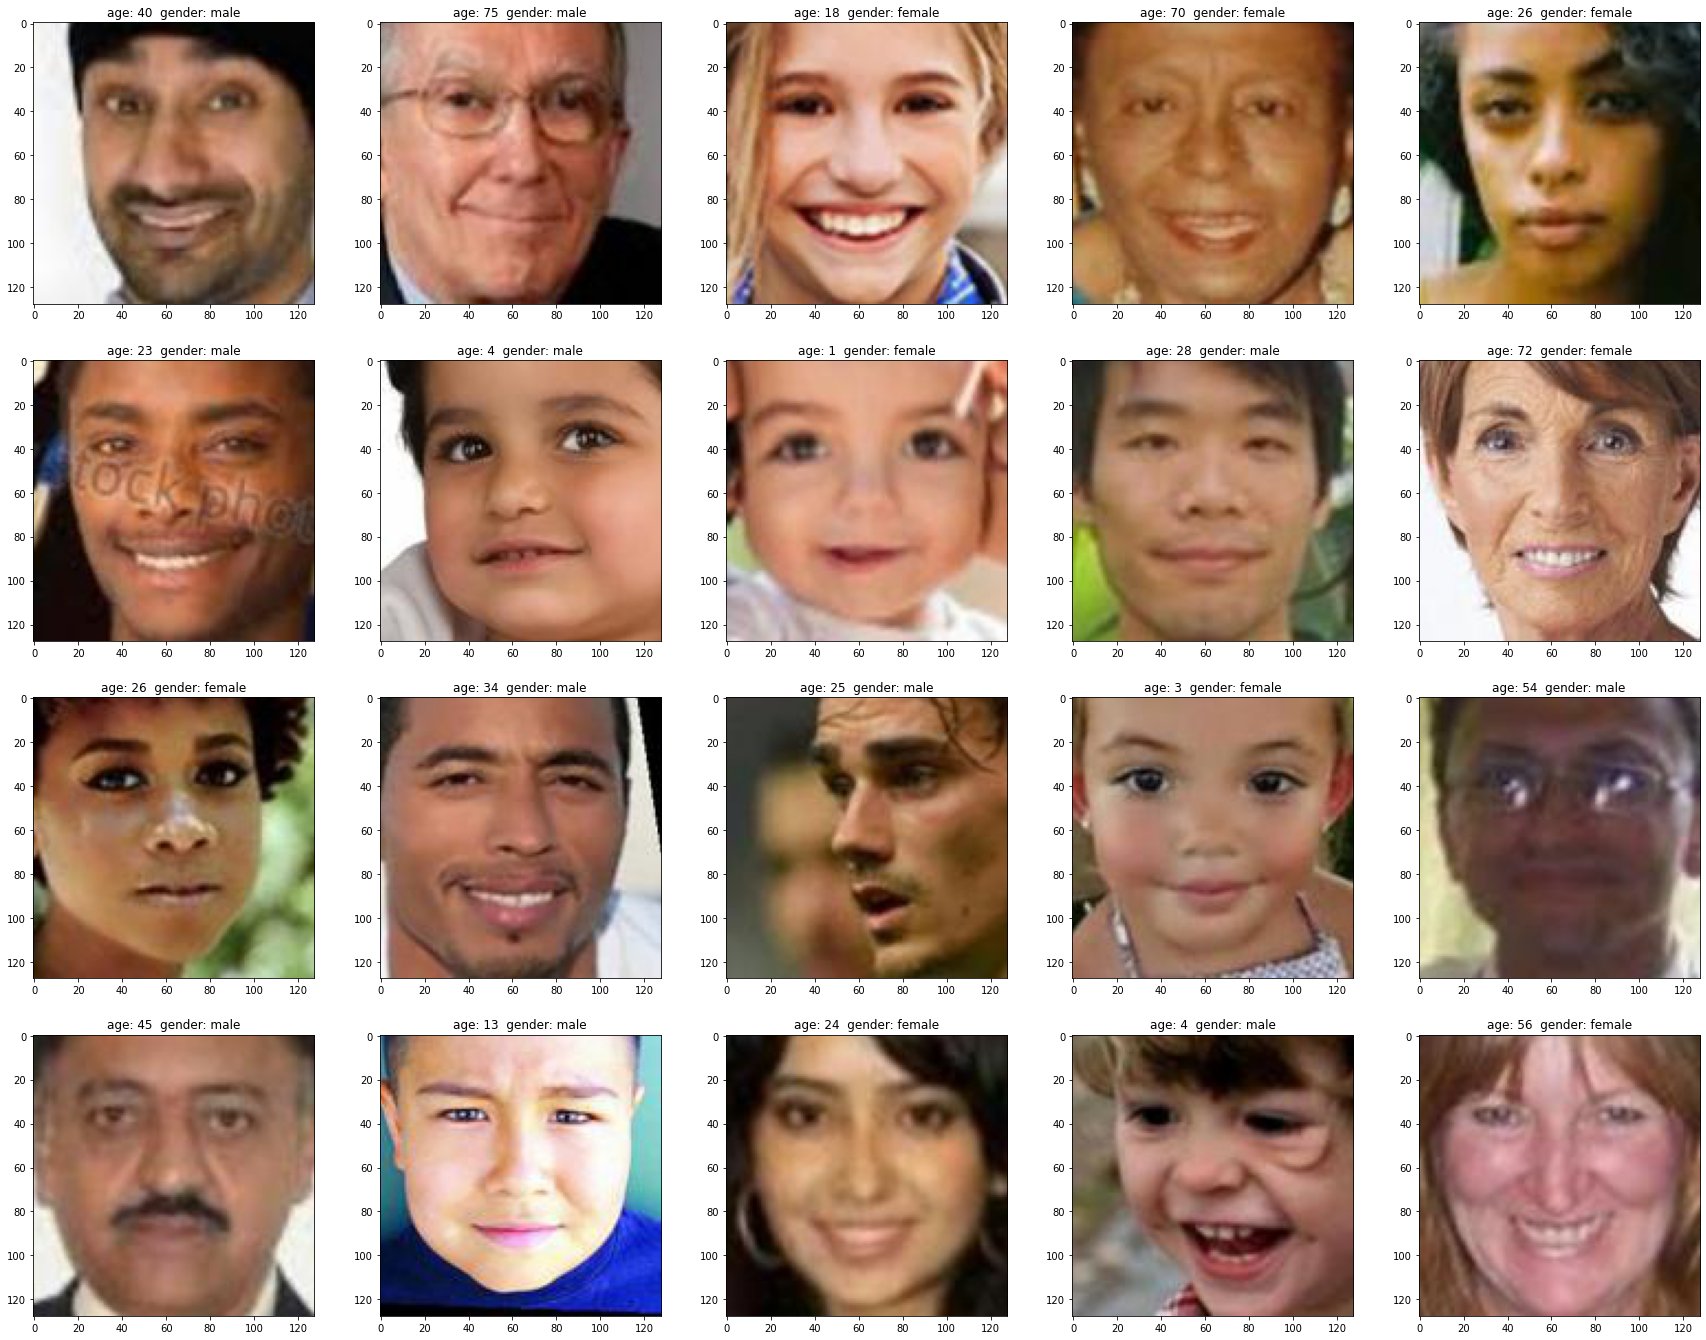

In [9]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder)[:20]:
        img = mpimg.imread(os.path.join(folder,filename))
        if img is not None:
            images.append((img, filename))
    return images

images = load_images_from_folder("/content/drive/MyDrive/train_val")
plt.figure(figsize=(30,30))
columns = 5
gender_dict = {0: "male", 1: "female"}
for i, (image, fname) in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    age, gender, race, time = fname.split('_')
    plt.title(f"age: {age}  gender: {gender_dict[int(gender)]}")
    plt.imshow(image)

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [10]:
df = pd.DataFrame(columns=['filename', 'age', 'gender', 'race'])

for filename in os.listdir(DIR):
  age, gender, race, time = filename.split('_')
  df.loc[len(df.index)] = [filename, float(age), float(gender), float(race)]

df.head()

filename   age  gender  race
0  40_0_3_20170119183403621.jpg.chip.jpg  40.0     0.0   3.0
1  75_0_0_20170117174511134.jpg.chip.jpg  75.0     0.0   0.0
2  18_1_0_20170109213011914.jpg.chip.jpg  18.0     1.0   0.0
3  70_1_3_20170116224931319.jpg.chip.jpg  70.0     1.0   3.0
4  26_1_1_20170116232602440.jpg.chip.jpg  26.0     1.0   1.0

In [11]:
df_train, df_valid, _, _ = train_test_split(df, df, test_size=0.2, random_state=42)

df_train.head()

filename   age  gender  race
4227  54_0_0_20170104212610221.jpg.chip.jpg  54.0     0.0   0.0
4676  63_0_0_20170117161116206.jpg.chip.jpg  63.0     0.0   0.0
800   21_1_1_20170112202846794.jpg.chip.jpg  21.0     1.0   1.0
3671  72_1_1_20170120225033578.jpg.chip.jpg  72.0     1.0   1.0
4193  88_0_0_20170111222556305.jpg.chip.jpg  88.0     0.0   0.0

In [12]:
df_valid.head()

filename   age  gender  race
1501  35_0_0_20170116233443386.jpg.chip.jpg  35.0     0.0   0.0
2586  38_1_0_20170104171602219.jpg.chip.jpg  38.0     1.0   0.0
2653  28_1_1_20170113012030016.jpg.chip.jpg  28.0     1.0   1.0
1055  48_0_0_20170120134009260.jpg.chip.jpg  48.0     0.0   0.0
705   26_0_2_20170116175514457.jpg.chip.jpg  26.0     0.0   2.0

## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 8,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    # shear_range = 0.2,
    zoom_range = 0.2,
    # horizontal_flip = True,
    fill_mode = 'nearest',
    brightness_range=[0.2,0.8])

valid_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_dataframe(dataframe=df_train, directory=DIR,
                                             x_col='filename',
                                             y_col=['gender', 'age'],
                                             target_size=(128,128),
                                             class_mode='multi_output',
                                             batch_size=50,
                                             seed=42)

validation_generator = valid_datagen.flow_from_dataframe(dataframe=df_valid, directory=DIR,
                                             x_col='filename',
                                             y_col=['gender', 'age'],
                                             target_size=(128,128),
                                             class_mode='multi_output',
                                             batch_size=50,
                                             seed=42)

Found 4000 validated image filenames.
Found 1000 validated image filenames.


## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                             

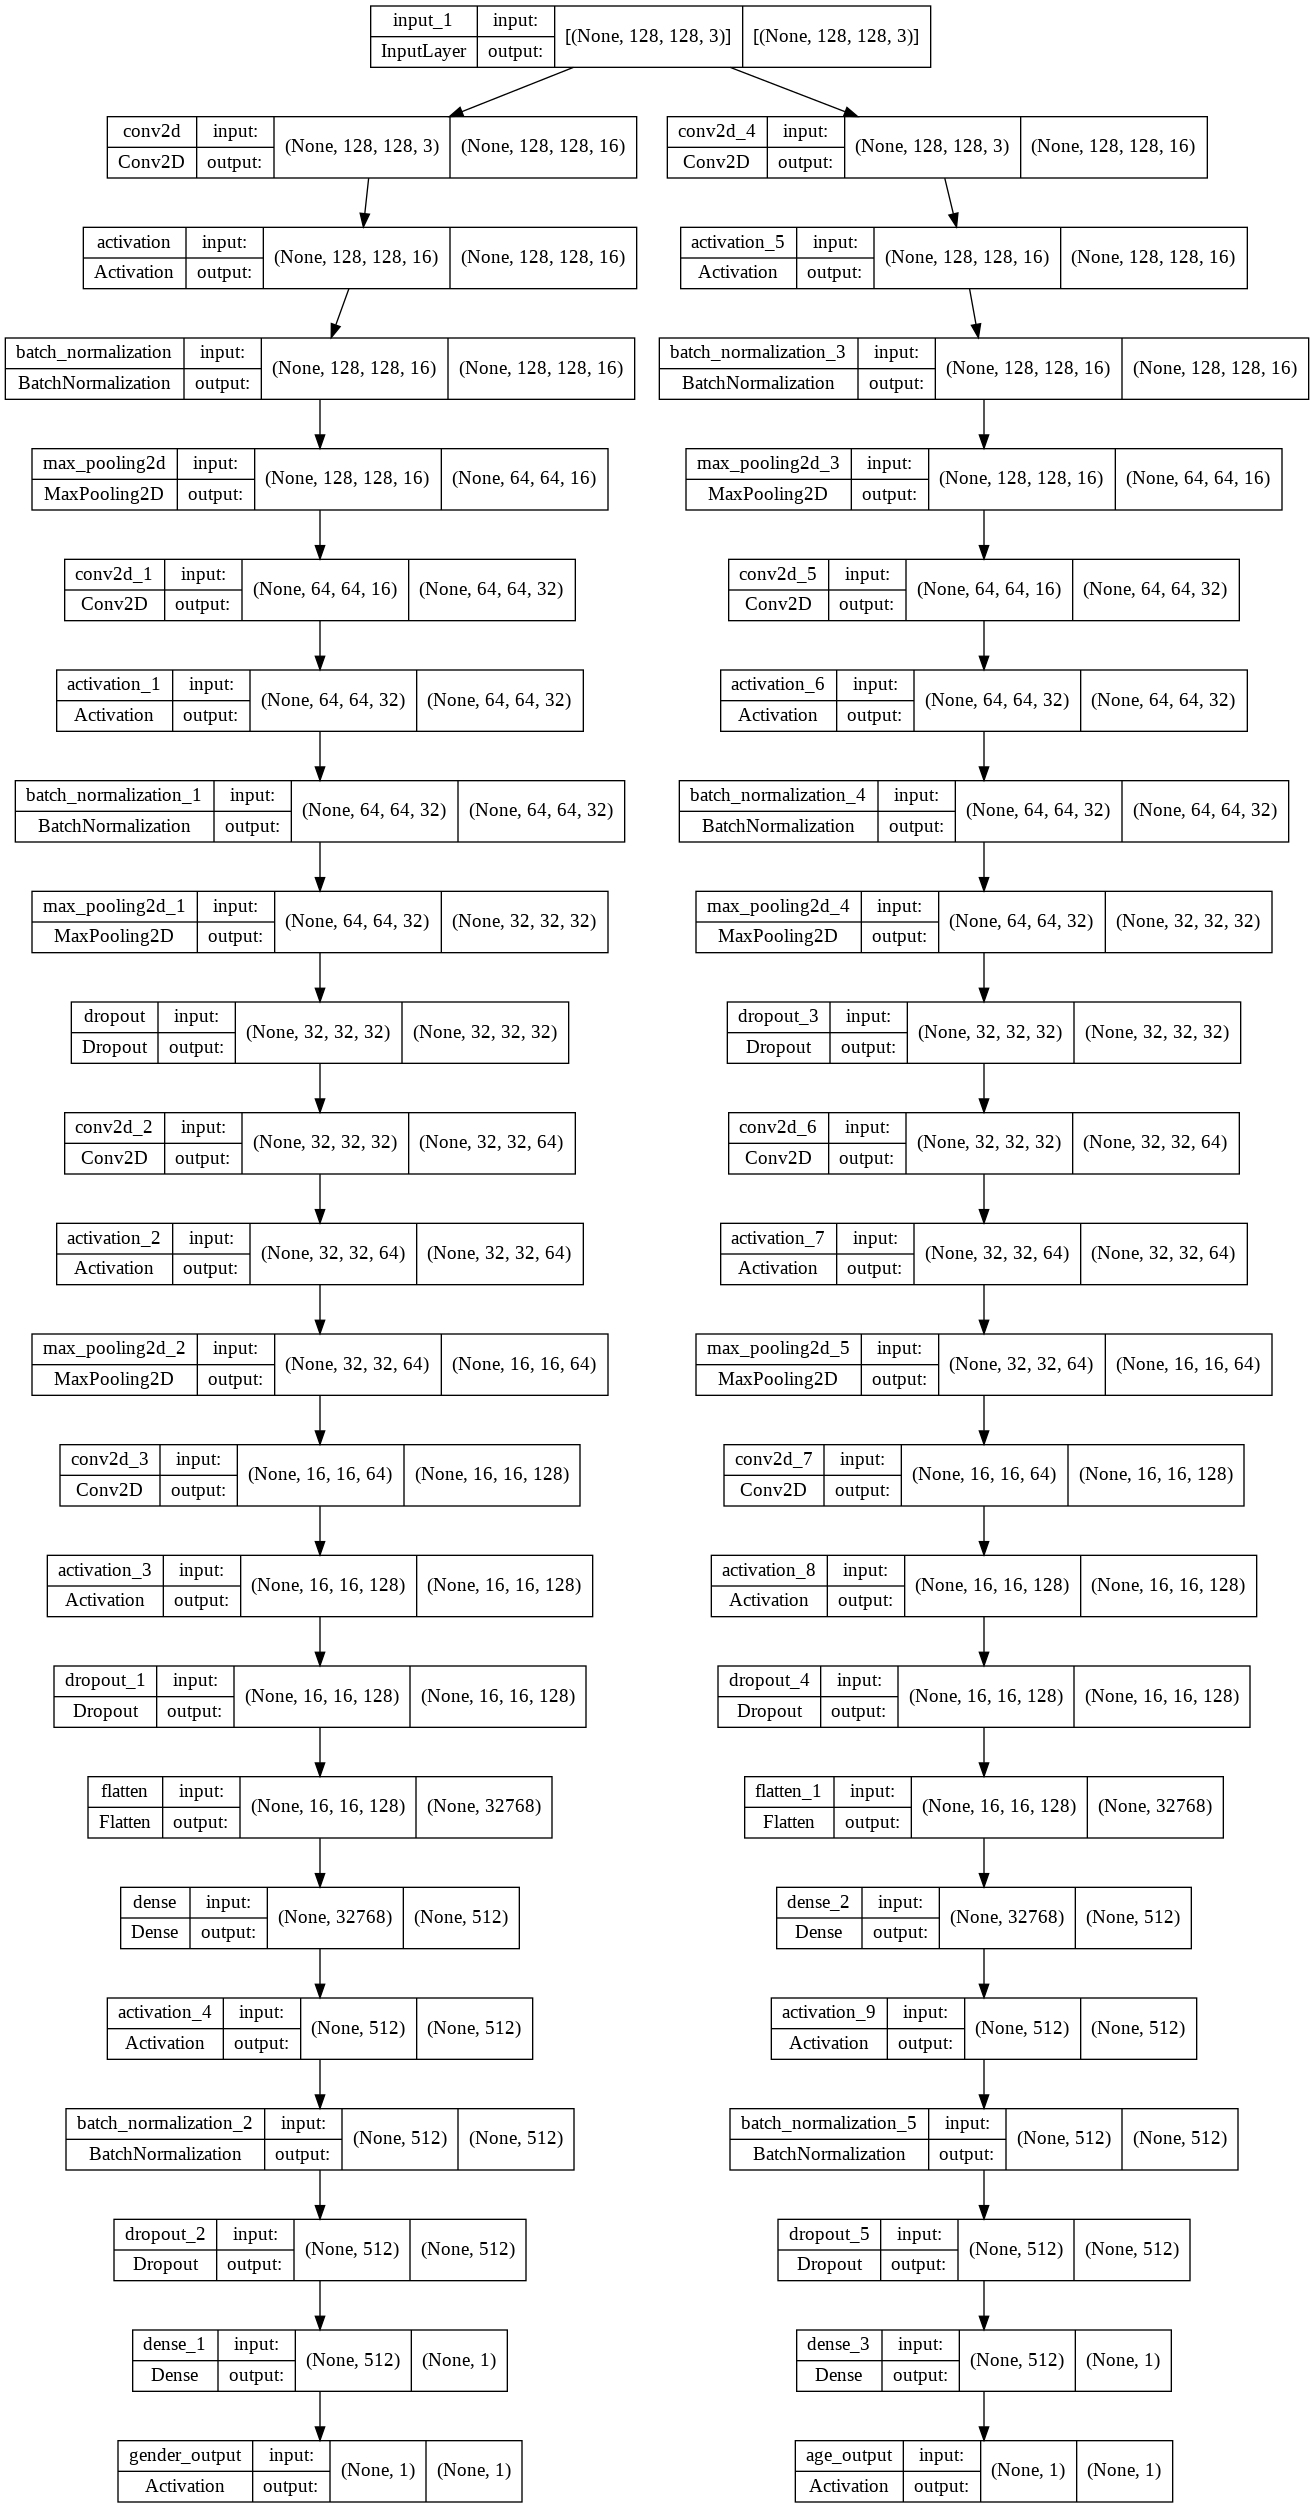

In [14]:
#
##

# CHANGE ARCHITECTURE OF CNN IN THIS CELL (REMEMBER OUTPUT LAYERS SHOULD STAY 1 UNIT)
# CAN ALSO CHANGE OPTIMISER
# MAYBE EVEN TRY CHANGING WEIGHTING OF LOSSES

##
#

DROPOUT = 0.25

# INITIAL FEATURE EXTRACTION CNN
input_layer = Input(shape=(128,128,3))

b = Conv2D(16, (3, 3), padding="same")(input_layer)
b = Activation("relu")(b)
b = BatchNormalization(axis=-1)(b)
b = MaxPooling2D(pool_size=(2, 2))(b)
b = Conv2D(32, (3, 3), padding="same")(b)
b = Activation("relu")(b)
b = BatchNormalization(axis=-1)(b)
b = MaxPooling2D(pool_size=(2, 2))(b)
b = Dropout(DROPOUT)(b)
b = Conv2D(64, (3, 3), padding="same")(b)
b = Activation("relu")(b)
b = MaxPooling2D(pool_size=(2, 2))(b)
b = Conv2D(128, (3, 3), padding="same")(b)
b = Activation("relu")(b)
b = Dropout(DROPOUT)(b)

# GENDER BRANCH
b = Flatten()(b)
b = Dense(512)(b)
b = Activation("relu")(b)
b = BatchNormalization()(b)
b = Dropout(DROPOUT)(b)

# SHOULD NOT CHANGE
b = Dense(1)(b)
b = Activation("sigmoid", name="gender_output")(b)

c = Conv2D(16, (3, 3), padding="same")(input_layer)
c = Activation("relu")(c)
c = BatchNormalization(axis=-1)(c)
c = MaxPooling2D(pool_size=(2, 2))(c)
c = Conv2D(32, (3, 3), padding="same")(c)
c = Activation("relu")(c)
c = BatchNormalization(axis=-1)(c)
c = MaxPooling2D(pool_size=(2, 2))(c)
c = Dropout(DROPOUT)(c)
c = Conv2D(64, (3, 3), padding="same")(c)
c = Activation("relu")(c)
c = MaxPooling2D(pool_size=(2, 2))(c)
c = Conv2D(128, (3, 3), padding="same")(c)
c = Activation("relu")(c)
c = Dropout(DROPOUT)(c)

# AGE BRANCH
c = Flatten()(c)
c = Dense(512)(c)
c = Activation("relu")(c)
c = BatchNormalization()(c)
c = Dropout(DROPOUT)(c)

# SHOULD NOT CHANGE
c = Dense(1)(c)
c = Activation("linear", name="age_output")(c)

modelA = Model(inputs=input_layer, outputs=[b, c])

modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True)

## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [16]:
train_steps = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

es_callback = EarlyStopping(monitor='val_loss', 
                            patience=20,
                            restore_best_weights=True)

EPOCHS = 150 

modelA.compile(optimizer="adam", 
              loss={'age_output': 'mse', 'gender_output': 'binary_crossentropy'},
              loss_weights={'age_output': 1., 'gender_output': 500.},
              metrics={'age_output': 'mae', 'gender_output': 'accuracy'})


history = modelA.fit_generator(train_generator,steps_per_epoch=train_steps, epochs=EPOCHS, validation_data=validation_generator,validation_steps=validation_steps, callbacks=[es_callback])

modelA.save("/content/drive/MyDrive/"+"age_gender_A.h5")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/150
80/80 [==============================] - 41s 343ms/step - loss: 1733.6860 - gender_output_loss: 0.7505 - age_output_loss: 1358.4310 - gender_output_accuracy: 0.6135 - age_output_mae: 31.7533 - val_loss: 1534.7997 - val_gender_output_loss: 0.6595 - val_age_output_loss: 1205.0449 - val_gender_output_accuracy: 0.6870 - val_age_output_mae: 29.2780
Epoch 2/150
80/80 [==============================] - 29s 356ms/step - loss: 1204.3287 - gender_output_loss: 0.6412 - age_output_loss: 883.7313 - gender_output_accuracy: 0.6532 - age_output_mae: 24.3980 - val_loss: 1678.0950 - val_gender_output_loss: 0.6582 - val_age_output_loss: 1348.9801 - val_gender_output_accuracy: 0.5780 - val_age_output_mae: 31.7668
Epoch 3/150
80/80 [==============================] - 27s 337ms/step - loss: 737.0798 - gender_output_loss: 0.6316 - age_output_loss: 421.2815 - gender_output_accuracy: 0.6618 - age_output_mae: 15.4617 - val_loss: 729.1925 - val_gender_output_loss: 0.6461 - val_age_output_loss: 406.146

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


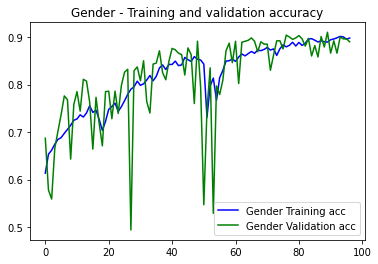

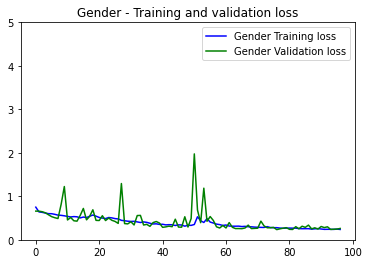

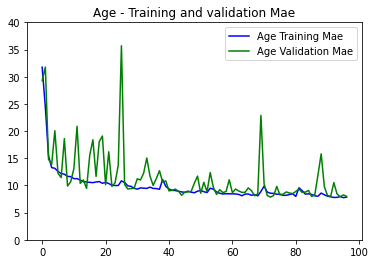

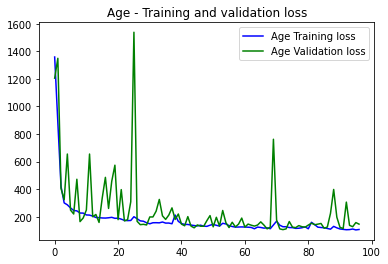

In [17]:
acc_gend = history.history['gender_output_accuracy']
val_acc_gend = history.history['val_gender_output_accuracy']
loss_gend = history.history['gender_output_loss']
val_loss_gend = history.history['val_gender_output_loss']
loss_age = history.history['age_output_loss']
val_loss_age = history.history['val_age_output_loss']
mae_age = history.history['age_output_mae']
val_mae_age = history.history['val_age_output_mae']

epochs = range(len(acc_gend))

plt.plot(epochs, acc_gend, 'b', label='Gender Training acc')
plt.plot(epochs, val_acc_gend, 'g', label='Gender Validation acc')
plt.title('Gender - Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_gend, 'b', label='Gender Training loss')
plt.plot(epochs, val_loss_gend, 'g', label='Gender Validation loss')
plt.ylim(0,5)
plt.title('Gender - Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, mae_age, 'b', label='Age Training Mae')
plt.plot(epochs, val_mae_age, 'g', label='Age Validation Mae')
plt.ylim(0,40)
plt.title('Age - Training and validation Mae')
plt.legend()

plt.figure()

plt.plot(epochs, loss_age, 'b', label='Age Training loss')
plt.plot(epochs, val_loss_age, 'g', label='Age Validation loss')
plt.title('Age - Training and validation loss')
plt.legend()

plt.show()

## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


In [21]:
# INITIAL FEATURE EXTRACTION CNN
cnn_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (128,128,3))

for layer in cnn_base.layers:
    layer.trainable = True
    if isinstance(layer, BatchNormalization):
        layer.momentum = 0.9
    
for layer in cnn_base.layers[:-50]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = False

# GENDER BRANCH
b = GaussianNoise(0.01)(cnn_base.output)
b = Flatten()(b)
b = Dense(256)(b)
b = Activation("relu")(b)
b = BatchNormalization()(b)
b = Dropout(0.8)(b)

# SHOULD NOT CHANGE
b = Dense(1)(b)
b = Activation("sigmoid", name="gender_output")(b)

# AGE BRANCH
c = GaussianNoise(0.01)(cnn_base.output)
c = Flatten()(c)
c = Dense(512)(c)
c = Activation("relu")(c)
c = BatchNormalization()(c)
c = Dropout(0.8)(c)

# SHOULD NOT CHANGE
c = Dense(1)(c)
c = Activation("linear", name="age_output")(c)

modelB = Model(inputs=cnn_base.input, outputs=[b, c])

modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_102 (Conv2D)            (None, 63, 63, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_102 (Batch  (None, 63, 63, 32)  96          ['conv2d_102[0][0]']             
 Normalization)                                                                                   
                                                                                            

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [22]:
train_steps = (train_generator.n//train_generator.batch_size)
validation_steps = (validation_generator.n//validation_generator.batch_size)

EPOCHS = 100

es_callback = EarlyStopping(monitor='val_loss', 
                            patience=30,
                            restore_best_weights=True)

modelB.compile(optimizer=Adam(0.01), 
              loss={'age_output': 'mse', 'gender_output': 'binary_crossentropy'},
              loss_weights={'age_output': 1., 'gender_output': 500.},
              metrics={'age_output': 'mae', 'gender_output': 'accuracy'})

historyB = modelB.fit_generator(train_generator,steps_per_epoch=train_steps, epochs=EPOCHS, validation_data=validation_generator,validation_steps=validation_steps, callbacks=[es_callback])

modelB.save("/content/drive/MyDrive/ML2_Lab/"+"age_gender_B.h5")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


Epoch 1/100
80/80 [==============================] - 42s 432ms/step - loss: 953.8984 - gender_output_loss: 0.7869 - age_output_loss: 560.4568 - gender_output_accuracy: 0.6382 - age_output_mae: 17.7606 - val_loss: 484.4521 - val_gender_output_loss: 0.5230 - val_age_output_loss: 222.9770 - val_gender_output_accuracy: 0.7370 - val_age_output_mae: 11.5380
Epoch 2/100
80/80 [==============================] - 33s 407ms/step - loss: 532.0676 - gender_output_loss: 0.6166 - age_output_loss: 223.7597 - gender_output_accuracy: 0.7372 - age_output_mae: 11.2178 - val_loss: 383.0307 - val_gender_output_loss: 0.4529 - val_age_output_loss: 156.5623 - val_gender_output_accuracy: 0.7940 - val_age_output_mae: 9.3774
Epoch 3/100
80/80 [==============================] - 36s 455ms/step - loss: 484.2944 - gender_output_loss: 0.5643 - age_output_loss: 202.1199 - gender_output_accuracy: 0.7617 - age_output_mae: 10.5828 - val_loss: 389.3695 - val_gender_output_loss: 0.4470 - val_age_output_loss: 165.8570 - val_

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

In [ ]:
acc_gend = historyB.history['gender_output_accuracy']
val_acc_gend = historyB.history['val_gender_output_accuracy']
loss_gend = historyB.history['gender_output_loss']
val_loss_gend = historyB.history['val_gender_output_loss']
loss_age = historyB.history['age_output_loss']
val_loss_age = historyB.history['val_age_output_loss']
mae_age = historyB.history['age_output_mae']
val_mae_age = historyB.history['val_age_output_mae']

epochs = range(len(acc_gend))

plt.plot(epochs, acc_gend, 'b', label='Gender Training acc')
plt.plot(epochs, val_acc_gend, 'g', label='Gender Validation acc')
plt.title('Gender - Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_gend, 'b', label='Gender Training loss')
plt.plot(epochs, val_loss_gend, 'g', label='Gender Validation loss')
plt.title('Gender - Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, mae_age, 'b', label='Age Training Mae')
plt.plot(epochs, val_mae_age, 'g', label='Age Validation Mae')
plt.title('Age - Training and validation Mae')
plt.legend()

plt.figure()

plt.plot(epochs, loss_age, 'b', label='Age Training loss')
plt.plot(epochs, val_loss_age, 'g', label='Age Validation loss')
plt.title('Age - Training and validation loss')
plt.legend()

plt.show()

## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#